In [1]:
# Librerias utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import warnings

## Importación de datos

In [2]:
csv_names  = ['df_DHCMA', 'df_CHG', 'df_CHGUADIANA',
            'df_CHS', 'df_DHGB', 'df_DHTOP']
path = '..\\DATA\\'
keys_names = ['Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas', 'Cuenca hidrográfica del Guadalquivir', 'Cuenca hidrográfica del Guadiana',
              'Cuenca hidrográfica del Segura', 'Demarcación Hidrográfica Guadalete-Barbate', 'Demarcación Hidrográfica Tinto, Odiel y Piedras']
df_dict = {key: pd.read_csv(path+value+'.csv', sep=',', encoding='ISO-8859-1')
           for key, value in zip(keys_names, csv_names)}

## Procesado de datos de entrada

In [3]:
# Función de creación de dataset sequencial con arrays de valores input/output
# Este dataset tiene la estructura adecuada para los datos de entrada
# en la red neuronal
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs.iloc[i:(i+seq_size)]
        after_window = obs.iloc[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [4]:
# Creación del dataset de indice SPI_12
spi_12_dict =  {key: value['spi_12']
           for key, value in df_dict.items()}

# Eliminación valores vacios iniciales
for key, df in spi_12_dict.items():           
    spi_12_dict[key] = df.dropna(how='all')       

In [5]:
# Separación en conjunto de entrenamiento y de prueba
# Los datos de prueba empiezan a partir de 2011
spi_12_train_dict, spi_12_test_dict = {}, {}
for key, df in spi_12_dict.items():
    df_train, df_test = train_test_split(df, test_size=0.13, shuffle=False)
    spi_12_train_dict[key] = df_train
    spi_12_test_dict[key] = df_test

In [6]:
# Cálculo de datasets sequenciales
sequence_size = 10
X_train_dict, y_train_dict, X_test_dict,y_test_dict = {}, {}, {}, {}

for key, df in spi_12_train_dict.items():
    X_train,y_train = to_sequences(sequence_size, df)
    X_train_dict[key] = X_train
    y_train_dict[key] = y_train

for key, df in spi_12_test_dict.items():
    X_test,y_test = to_sequences(sequence_size, df)
    X_test_dict[key] = X_test
    y_test_dict[key] = y_test

print("Dimensiones del training set: {}".format(X_train_dict[keys_names[0]].shape))
print("Dimensiones del test set: {}".format(X_test_dict[keys_names[0]].shape))

Dimensiones del training set: (836, 10, 1)
Dimensiones del test set: (117, 10, 1)


# Definición del modelo

In [7]:
def create_model(n_nodes=20, optimizer='adam', activation='relu'):
    # Arquitectura del modelo
    model = Sequential()
    model.add(Dense(n_nodes, activation=activation, input_dim=X_train.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    return model

#  Early stopping para evitar overfitting
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

### Grid search: búsqueda de mejores parámetros

In [8]:
# Transformación del modelo para aplicar grid search
model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0, activation='relu', n_nodes=20)

# Parámetros de búsqueda
param_grid = {
    'n_nodes': [10,20, 50],
    'epochs': [50, 100],
    'batch_size' : [5,10,20],
    'optimizer' : ['SGD', 'adam'], 
    'activation' : ['relu', 'tanh']
}



# Se ignoran avisos de ejecución del grid search
warnings.simplefilter("ignore")

# Cálculo de grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=8)
grid_result_dict = {}
for key in spi_12_train_dict.keys():
    grid_result_dict[key] = grid.fit(X_train_dict[key], y_train_dict[key], callbacks=[es], shuffle=False, validation_data=(
        X_test_dict[key], y_test_dict[key]))
    print(key)
    print("Best: %f using %s" % (grid_result_dict[key].best_score_, grid_result_dict[key].best_params_))
    print('')

Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas
Best: 0.848539 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100, 'n_nodes': 10, 'optimizer': 'SGD'}

Cuenca hidrográfica del Guadalquivir
Best: 0.873958 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100, 'n_nodes': 20, 'optimizer': 'SGD'}

Cuenca hidrográfica del Guadiana
Best: 0.872505 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100, 'n_nodes': 20, 'optimizer': 'adam'}

Cuenca hidrográfica del Segura
Best: 0.882638 using {'activation': 'relu', 'batch_size': 20, 'epochs': 100, 'n_nodes': 50, 'optimizer': 'SGD'}

Demarcación Hidrográfica Guadalete-Barbate
Best: 0.854614 using {'activation': 'relu', 'batch_size': 10, 'epochs': 100, 'n_nodes': 20, 'optimizer': 'SGD'}

Demarcación Hidrográfica Tinto, Odiel y Piedras
Best: 0.872343 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100, 'n_nodes': 20, 'optimizer': 'SGD'}



# Entrenamiento del modelo

In [9]:
model_history_dict = {}

for key in spi_12_train_dict.keys():
    model = create_model(grid_result_dict[key].best_params_['n_nodes'], grid_result_dict[key].best_params_[
                         'optimizer'], grid_result_dict[key].best_params_['activation'])

    model_history_dict[key] = model.fit(X_train_dict[key], y_train_dict[key], epochs=grid_result_dict[key].best_params_['epochs'],
        batch_size=grid_result_dict[key].best_params_['batch_size'],
        validation_data=(
        X_test_dict[key], y_test_dict[key]), verbose=2, shuffle=False, callbacks=[es]
        )


Epoch 1/100
84/84 - 0s - loss: 0.0631 - mse: 0.0631 - val_loss: 0.0558 - val_mse: 0.0558 - 472ms/epoch - 6ms/step
Epoch 2/100
84/84 - 0s - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0445 - val_mse: 0.0445 - 70ms/epoch - 834us/step
Epoch 3/100
84/84 - 0s - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0364 - val_mse: 0.0364 - 67ms/epoch - 798us/step
Epoch 4/100
84/84 - 0s - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0304 - val_mse: 0.0304 - 69ms/epoch - 822us/step
Epoch 5/100
84/84 - 0s - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0258 - val_mse: 0.0258 - 69ms/epoch - 822us/step
Epoch 6/100
84/84 - 0s - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0224 - val_mse: 0.0224 - 66ms/epoch - 786us/step
Epoch 7/100
84/84 - 0s - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0197 - val_mse: 0.0197 - 68ms/epoch - 810us/step
Epoch 8/100
84/84 - 0s - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0176 - val_mse: 0.0176 - 67ms/epoch - 798us/step
Epoch 9/100
84/84 - 0s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0160 - val_mse:

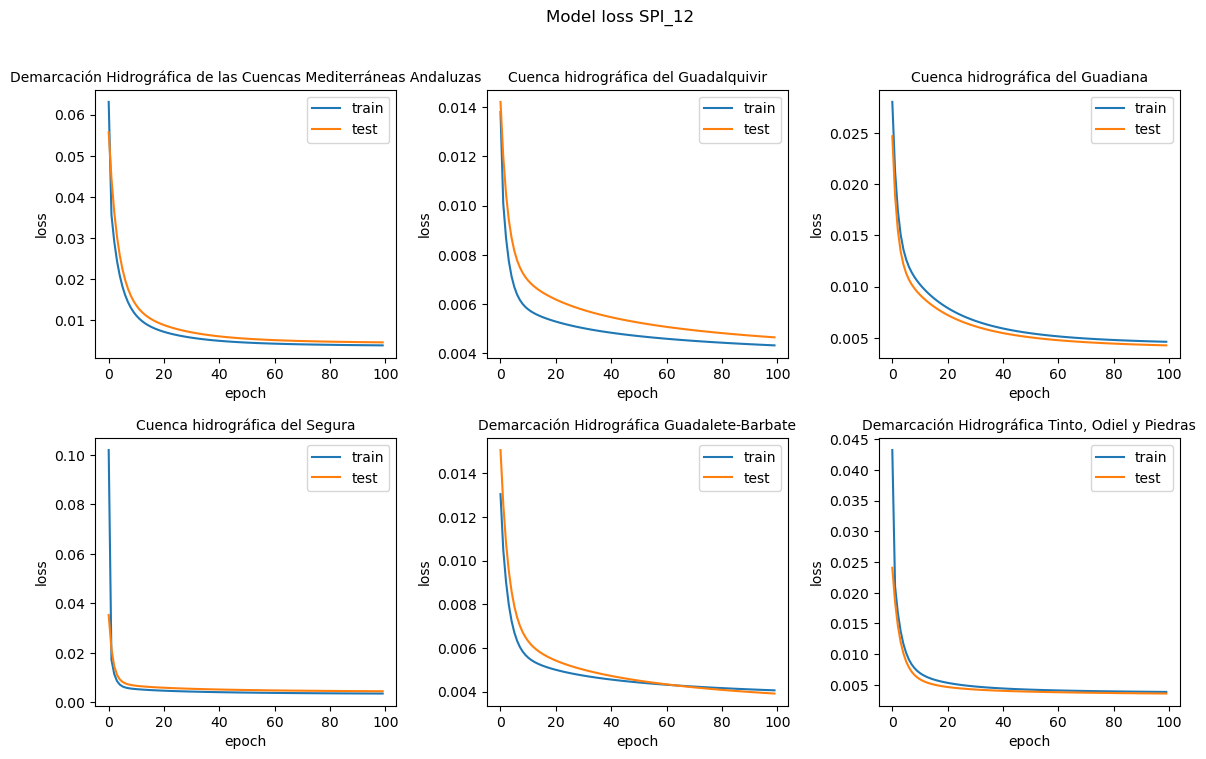

In [10]:
# Resumen del entrenamiento
n_rows = 2
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(14,8))
fig.suptitle('Model loss SPI_12')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, (key, value) in enumerate(model_history_dict.items()):
    if i<n_cols:
        ax[0, i].plot(value.history['loss'])
        ax[0, i].plot(value.history['val_loss'])
        ax[0, i].set_title(key, fontsize=10)
        ax[0, i].set_ylabel('loss')
        ax[0, i].set_xlabel('epoch')
        ax[0, i].legend(['train', 'test'], loc='upper right')
    else:
        ax[1, i-n_cols].plot(value.history['loss'])
        ax[1, i-n_cols].plot(value.history['val_loss'])
        ax[1, i-n_cols].set_title(key, fontsize=10)
        ax[1, i-n_cols].set_ylabel('loss')
        ax[1, i-n_cols].set_xlabel('epoch')
        ax[1, i-n_cols].legend(['train', 'test'], loc='upper right')

# Evaluación del modelo

In [11]:
test_score_values = []
for key in spi_12_dict.keys():
    print('Evaluación '+ key)
    train_prediction = model.predict(X_train_dict[key], verbose=0)
    test_prediction = model.predict(X_test_dict[key], verbose=0)
    train_score = model.evaluate(X_train_dict[key], y_train_dict[key], verbose=0)
    test_score = model.evaluate(X_test_dict[key], y_test_dict[key], verbose=0)
    test_score_values.append(test_score[0])
    print('Train score: {} MSE'.format(train_score[0]))
    print('Test score: {} MSE'.format(test_score[0]))
    print('')

mean_test_score = sum(test_score_values) / len(test_score_values)
print('MLP SPI_12 Mean Test score: {} MSE'.format(mean_test_score))

Evaluación Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas
Train score: 0.0048028104938566685 MSE
Test score: 0.005660890135914087 MSE

Evaluación Cuenca hidrográfica del Guadalquivir
Train score: 0.004858348518610001 MSE
Test score: 0.00461864797398448 MSE

Evaluación Cuenca hidrográfica del Guadiana
Train score: 0.00520335603505373 MSE
Test score: 0.004704213701188564 MSE

Evaluación Cuenca hidrográfica del Segura
Train score: 0.004220373462885618 MSE
Test score: 0.004811499267816544 MSE

Evaluación Demarcación Hidrográfica Guadalete-Barbate
Train score: 0.004679610952734947 MSE
Test score: 0.004397651646286249 MSE

Evaluación Demarcación Hidrográfica Tinto, Odiel y Piedras
Train score: 0.004037919454276562 MSE
Test score: 0.003604185301810503 MSE

MLP SPI_12 Mean Test score: 0.0046328480045000715 MSE


# Visualización de la predicción

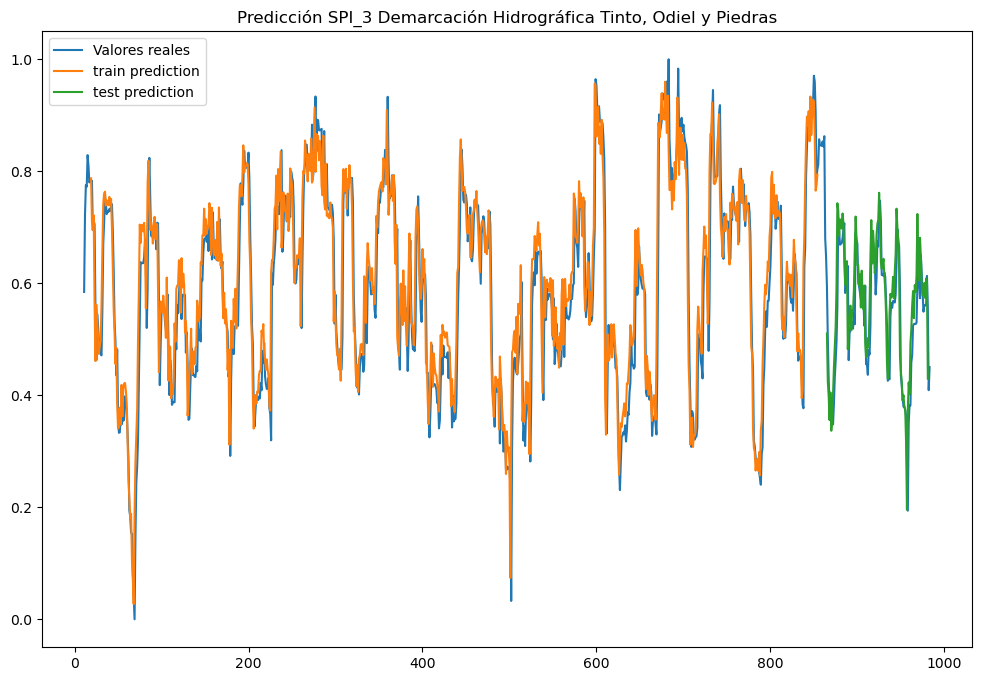

In [12]:
# Gráfica con los valores reales frente a los datos de predicción
# Se usa como ejemplo la predicción de la Demarcación Hidrográfica Tinto, Odiel y Piedras
plt.figure(figsize=(12, 8))
train_stamp = np.arange(9+sequence_size, 9+sequence_size + X_train_dict[keys_names[5]].shape[0])
test_stamp = np.arange(9+2 * sequence_size + X_train_dict[keys_names[5]].shape[0], 9+len(spi_12_dict[keys_names[5]]))
plt.plot(spi_12_dict[keys_names[5]], label='Valores reales')
plt.plot(train_stamp, train_prediction, label='train prediction')
plt.plot(test_stamp, test_prediction, label = 'test prediction')
plt.title('Predicción SPI_3 '+ keys_names[5])
plt.legend()
plt.show()